In [1]:
# For Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, Conv2D, MaxPool2D, Flatten, Reshape
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')

# Functions

In [3]:
def get_predictions(text, model, all=False):
    clean = re.sub(r'[^ a-z A-Z 0-9]', ' ', text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    # print(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
    x = padding_doc(test_ls, max_length)
    pred = model.predict(x)
    id = np.argmax(pred)
    if all:
      return pred
    return df['intent'].unique()[id]

In [4]:
# For Colab
PATH = '/content/drive/MyDrive/Colab Notebooks/21/intent/data/'
NLTK_PATH = '/content/drive/MyDrive/Colab Notebooks/21/intent/nltk_data/'
roc_auc_matrix = pd.DataFrame(columns=['model','roc_auc'])

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read data

In [6]:
# df = pd.read_csv(PATH+'intents_train.csv', header=0)
df = pd.read_csv(PATH+'intents_train_new.csv', header=0)
df.head()

,text,intent
0,Carbon fiber bike,Bike Types
1,budget bikes,Bike Types
2,professional bikes,Bike Types
3,bikes for men,Bike Types
4,bikes for women,Bike Types


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    118 non-null    object
 1   intent  118 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [8]:
df['intent'].unique()

array(['Bike Types', 'Cost Estimation', 'Hours', 'Make Appointment',
       'Return Policy', 'Trade-in Options', 'Welcome Intent'],
      dtype=object)

In [9]:
df['intent'] = df['intent'].replace(['Bike Types', 'Cost Estimation', 'Make Appointment', 'Return Policy', 'Trade-in Options', 'Welcome Intent'],
                                    ['Bike.Types', 'Cost.Estimation', 'Make.Appointment', 'Return.Policy', 'Trade.in.Options', 'Welcome.Intent'])

In [10]:
# define stemmer
stemmer = LancasterStemmer()

In [11]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', ' ', s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
      
    return words  

In [12]:
cleaned_words = cleaning(df['text'])
print(len(cleaned_words))
print(cleaned_words[:2])

118
[['carbon', 'fiber', 'bike'], ['budget', 'bikes']]


In [13]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters=filters)
    token.fit_on_texts(words)
    
    return token

In [14]:
def max_length(words):
    return(len(max(words, key=len)))

In [15]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)
print(f'Vocab Size = {vocab_size} and Maximum length = {max_length}')

Vocab Size = 153 and Maximum length = 14


In [16]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [17]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [18]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen=max_length, padding='post'))

In [19]:
padded_doc = padding_doc(encoded_doc, max_length)

In [20]:
padded_doc[:5]

array([[74, 75,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [51,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [52,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  4, 76,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  4, 77,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

In [21]:
print(f'Shape of padded docs = {padded_doc.shape}')

Shape of padded docs = (118, 14)


In [22]:
# tokenizer with filter changed
output_tokenizer = create_tokenizer(df['intent'].unique(), filters='!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [23]:
output_tokenizer.word_index

{'bike.types': 1,
 'cost.estimation': 2,
 'hours': 3,
 'make.appointment': 4,
 'return.policy': 5,
 'trade.in.options': 6,
 'welcome.intent': 7}

In [24]:
encoded_output = encoding_doc(output_tokenizer, df['intent'])

In [25]:
encoded_output = np.array(encoded_output, dtype=object).reshape(len(encoded_output), 1)

In [26]:
encoded_output.shape

(118, 1)

In [27]:
def one_hot(encode):
    o = OneHotEncoder(sparse=False)
    
    return(o.fit_transform(encode))

In [28]:
output_one_hot = one_hot(encoded_output)

In [29]:
output_one_hot.shape

(118, 7)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(padded_doc, output_one_hot, shuffle=True, test_size=0.2, random_state=21)

In [31]:
print(f'Shape of train_X = {X_train.shape} and train_Y = {y_train.shape}')
print(f'Shape of val_X = {X_test.shape} and val_Y = {y_test.shape}')

Shape of train_X = (94, 14) and train_Y = (94, 7)
Shape of val_X = (24, 14) and val_Y = (24, 7)


# RNN model

In [32]:
def create_model_rnn(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 64, input_length=max_length, mask_zero=True))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    return model

In [33]:
model_rnn = create_model_rnn(vocab_size, max_length)
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 64)            9792      
                                                                 
 bidirectional (Bidirectiona  (None, 14, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 4

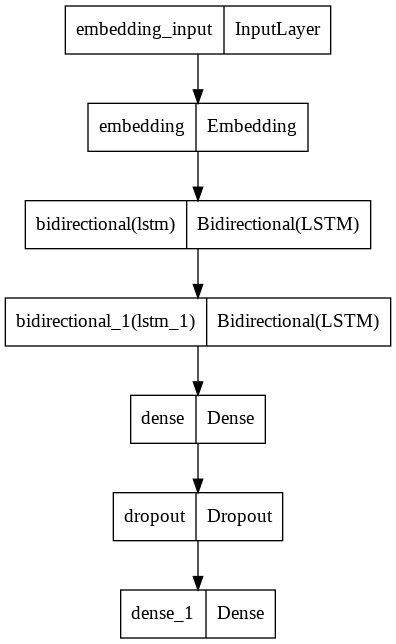

In [34]:
tf.keras.utils.plot_model(model_rnn)

In [35]:
model_rnn_filename = 'model_rnn.h5'
checkpoint = ModelCheckpoint(PATH+model_rnn_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_rnn.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
2/3 [===================>..........] - ETA: 0s - loss: 1.9453 - acc: 0.1719 
Epoch 1: val_loss improved from inf to 1.94111, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_rnn.h5
3/3 [==============================] - 31s 3s/step - loss: 1.9445 - acc: 0.2021 - val_loss: 1.9411 - val_acc: 0.1250
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 1.9384 - acc: 0.2234
Epoch 2: val_loss improved from 1.94111 to 1.93816, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_rnn.h5
3/3 [==============================] - 0s 104ms/step - loss: 1.9384 - acc: 0.2234 - val_loss: 1.9382 - val_acc: 0.2500
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 1.9302 - acc: 0.2660
Epoch 3: val_loss improved from 1.93816 to 1.93384, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_rnn.h5
3/3 [==============================] - 0s 104ms/step - loss: 1.9302 - acc: 0.2660 - val_loss: 1.9338 

In [36]:
loss, accuracy = model_rnn.evaluate(X_train, y_train)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

3/3 [==============================] - 0s 13ms/step - loss: 0.0334 - acc: 0.9894
Loss: 0.03343779966235161
Accuracy: 0.9893617033958435


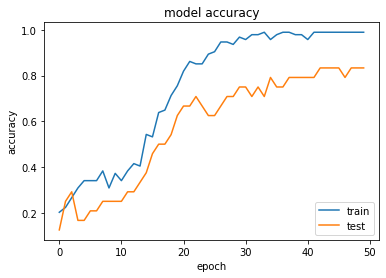

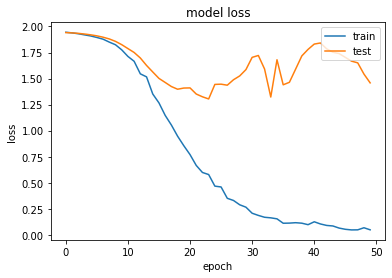

In [37]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [38]:
roc_auc_matrix = roc_auc_matrix.append(pd.Series(data={'model': 'model RNN: Embedding (64), Bidirectional(LSTM(64)), Bidirectional(LSTM(32)), Dense(64), Dropout(0.5), Dense(7)',
                                                       'roc_auc': round(roc_auc_score(label_binarize(df['intent'], classes=df['intent'].unique()),
                                                                                      label_binarize(df['text'].apply(get_predictions, model=model_rnn), classes=df['intent'].unique()),
                                                                                      multi_class='ovr'), 3)
                                                       }), ignore_index=True)

# LSTM model

In [39]:
def create_model_lstm(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 64, input_length=max_length, mask_zero=True))
    model.add(LSTM(10))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    return model

In [40]:
model_lstm = create_model_lstm(vocab_size, max_length)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 14, 64)            9792      
                                                                 
 lstm_2 (LSTM)               (None, 10)                3000      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                704       
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)               

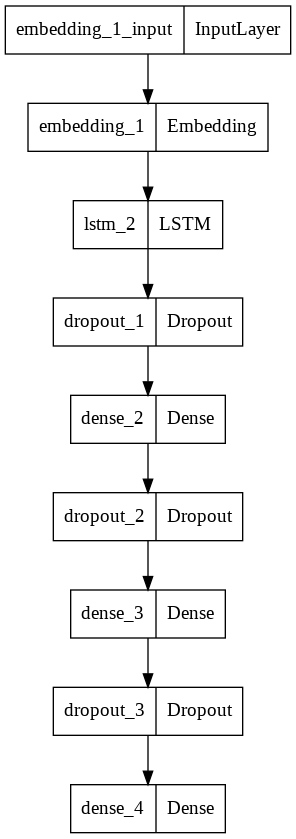

In [41]:
tf.keras.utils.plot_model(model_lstm)

In [42]:
model_lstm_filename = 'model_lstm.h5'
checkpoint = ModelCheckpoint(PATH+model_lstm_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_lstm.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/100
1/3 [=========>....................] - ETA: 9s - loss: 1.9457 - acc: 0.0625
Epoch 1: val_loss improved from inf to 1.94453, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_lstm.h5
3/3 [==============================] - 7s 932ms/step - loss: 1.9440 - acc: 0.0957 - val_loss: 1.9445 - val_acc: 0.1250
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 1.9429 - acc: 0.1875
Epoch 2: val_loss improved from 1.94453 to 1.94292, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_lstm.h5
3/3 [==============================] - 0s 52ms/step - loss: 1.9413 - acc: 0.2128 - val_loss: 1.9429 - val_acc: 0.1250
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 1.9387 - acc: 0.1562
Epoch 3: val_loss improved from 1.94292 to 1.94164, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_lstm.h5
3/3 [==============================] - 0s 54ms/step - loss: 1.9370 - acc: 0.2021 - val_loss: 1.

In [43]:
loss, accuracy = model_lstm.evaluate(X_train, y_train)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

3/3 [==============================] - 0s 6ms/step - loss: 0.3078 - acc: 0.9894
Loss: 0.3078301250934601
Accuracy: 0.9893617033958435


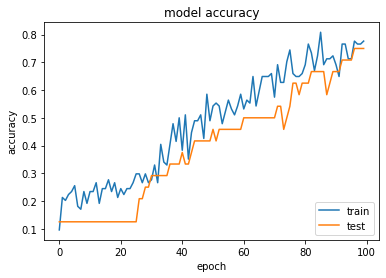

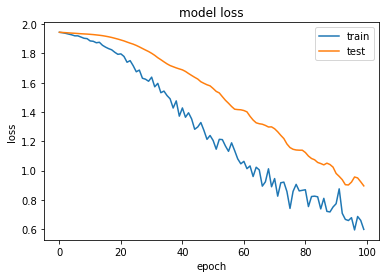

In [44]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [45]:
roc_auc_matrix = roc_auc_matrix.append(pd.Series(data={'model': 'model LSTM: Embedding (64), LSTM(10), Dense(64), Dropout(0.5), Dense(32), Dropout(0.5), Dense(7)',
                                                       'roc_auc': round(roc_auc_score(label_binarize(df['intent'], classes=df['intent'].unique()),
                                                                                      label_binarize(df['text'].apply(get_predictions, model=model_lstm), classes=df['intent'].unique()),
                                                                                      multi_class='ovr'), 3)
                                                       }), ignore_index=True)

# CNN

In [46]:
def create_model_cnn(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 64, input_length=max_length, mask_zero=True))
    model.add(Reshape((14,64,1)))
    model.add(Conv2D(256, kernel_size=(2, 64), padding='valid', kernel_initializer='normal', activation='relu'))
    model.add(MaxPool2D(pool_size=(14 - 2 + 1, 1), strides=(1,1), padding='valid'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    return model

In [47]:
model_cnn = create_model_cnn(vocab_size, max_length)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 14, 64)            9792      
                                                                 
 reshape (Reshape)           (None, 14, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 13, 1, 256)        33024     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 256)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

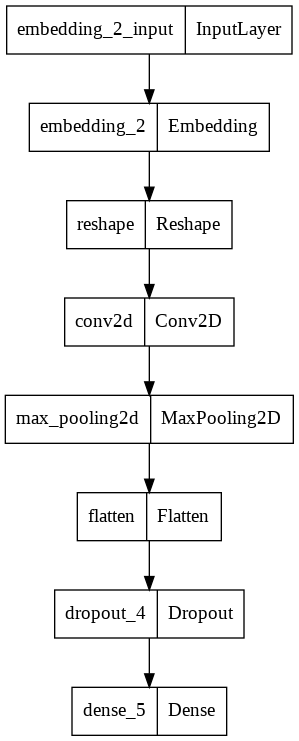

In [48]:
tf.keras.utils.plot_model(model_cnn)

In [49]:
model_cnn_filename = 'model_cnn.h5'
checkpoint = ModelCheckpoint(PATH+model_cnn_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_cnn.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
1/3 [=========>....................] - ETA: 1s - loss: 1.9584 - acc: 0.0625
Epoch 1: val_loss improved from inf to 1.93561, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_cnn.h5
3/3 [==============================] - 1s 259ms/step - loss: 1.9479 - acc: 0.0851 - val_loss: 1.9356 - val_acc: 0.2917
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 1.9227 - acc: 0.2812
Epoch 2: val_loss improved from 1.93561 to 1.92489, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_cnn.h5
3/3 [==============================] - 0s 52ms/step - loss: 1.9167 - acc: 0.3511 - val_loss: 1.9249 - val_acc: 0.3750
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 1.8847 - acc: 0.5000
Epoch 3: val_loss improved from 1.92489 to 1.91573, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_cnn.h5
3/3 [==============================] - 0s 39ms/step - loss: 1.8800 - acc: 0.5213 - val_loss: 1.9157 -

In [50]:
loss, accuracy = model_cnn.evaluate(X_train, y_train)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

3/3 [==============================] - 0s 5ms/step - loss: 0.0727 - acc: 0.9894
Loss: 0.07268126308917999
Accuracy: 0.9893617033958435


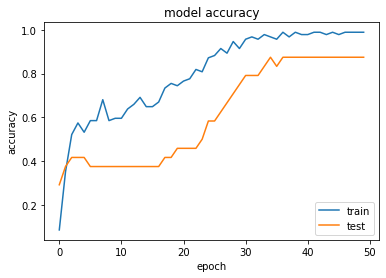

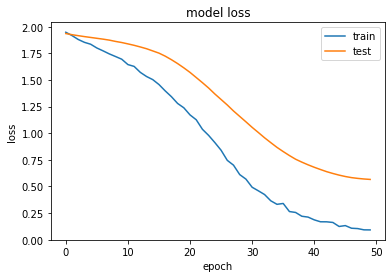

In [51]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [52]:
roc_auc_matrix = roc_auc_matrix.append(pd.Series(data={'model': 'model CNN: Embedding (64), Reshape(14,64,1), Conv2D(256), MaxPool2D(13,1), Flatten(), Dropout(0.5), Dense(7)',
                                                       'roc_auc': round(roc_auc_score(label_binarize(df['intent'], classes=df['intent'].unique()),
                                                                                      label_binarize(df['text'].apply(get_predictions, model=model_cnn), classes=df['intent'].unique()),
                                                                                      multi_class='ovr'), 3)
                                                       }), ignore_index=True)

# BERT model

In [53]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

In [54]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [55]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

In [56]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [57]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [58]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [59]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.40941042 -0.5673768  -0.9999843  -0.96458274  0.8787061  -0.14462373
 -0.75539255 -0.01419723  0.55393857  0.02157254 -0.77951187  0.06313917]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.21261796 -0.5496444   1.6522267  ... -0.4531066   0.5578209
  -0.8519268 ]
 [ 0.05303206 -0.5518504  -0.24887416 ... -0.10920344  0.40942514
  -0.30195045]
 [-0.47530103 -0.573211    0.3100407  ... -0.51567715  0.5689236
  -0.5102425 ]
 ...
 [ 0.424989   -0.43889523  1.1993048  ... -0.37663954  0.32898074
  -0.46796656]
 [ 0.2600221  -0.37434536  1.1515177  ... -0.31171423  0.28399193
  -0.34318137]
 [ 0.0461543  -0.24607307  1.1613255  ... -0.27085257  0.3557993
  -0.25757605]]


In [60]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(7, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [61]:
model_bert = build_classifier_model()
bert_raw_result = model_bert(tf.constant(text_test))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.13747658 0.12537432 0.1620897  0.14813165 0.13845347 0.15942602
  0.12904826]], shape=(1, 7), dtype=float32)


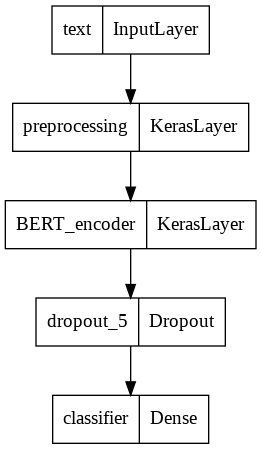

In [62]:
tf.keras.utils.plot_model(model_bert)

In [63]:
model_bert.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [64]:
X = df.drop(columns=['intent']).copy()
y = label_binarize(df['intent'], classes=df['intent'].unique())

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=21)

In [66]:
model_bert_filename = 'model_bert.h5'
checkpoint = ModelCheckpoint(PATH+model_bert_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model_bert.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 2.4489 - acc: 0.2234 
Epoch 1: val_loss improved from inf to 2.63818, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_bert.h5
3/3 [==============================] - 71s 20s/step - loss: 2.4489 - acc: 0.2234 - val_loss: 2.6382 - val_acc: 0.1667
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 2.5154 - acc: 0.2234 
Epoch 2: val_loss improved from 2.63818 to 2.47779, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_bert.h5
3/3 [==============================] - 57s 20s/step - loss: 2.5154 - acc: 0.2234 - val_loss: 2.4778 - val_acc: 0.1667
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 2.1411 - acc: 0.1915 
Epoch 3: val_loss improved from 2.47779 to 2.06428, saving model to /content/drive/MyDrive/Colab Notebooks/21/intent/data/model_bert.h5
3/3 [==============================] - 60s 20s/step - loss: 2.1411 - acc: 0.1915 - val_loss: 2.0643

In [67]:
loss, accuracy = model_bert.evaluate(X_train, y_train)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

3/3 [==============================] - 15s 5s/step - loss: 1.8055 - acc: 0.2234
Loss: 1.8055366277694702
Accuracy: 0.22340425848960876


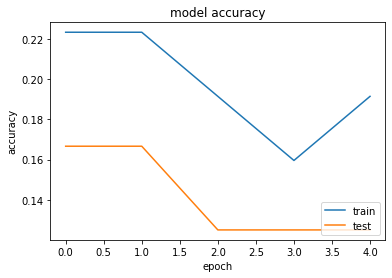

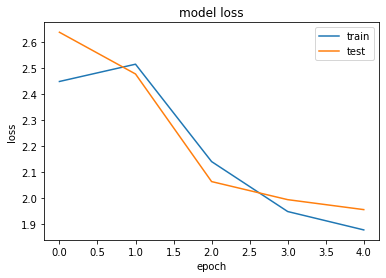

In [68]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [69]:
roc_auc_matrix = roc_auc_matrix.append(pd.Series(data={'model': 'model BERT: preprocessing, BERT_encoder, Dropout(0.5), Dense(7)',
                                                       'roc_auc': round(roc_auc_score(label_binarize(df['intent'], classes=df['intent'].unique()),
                                                                                      model_bert.predict(df['text']),
                                                                                      multi_class='ovr'), 3)
                                                       }), ignore_index=True)

# Conclusion

In [70]:
roc_auc_matrix

,model,roc_auc
0,"model RNN: Embedding (64), Bidirectional(LSTM(...",0.908
1,"model LSTM: Embedding (64), LSTM(10), Dense(64...",0.894
2,"model CNN: Embedding (64), Reshape(14,64,1), C...",0.912
3,"model BERT: preprocessing, BERT_encoder, Dropo...",0.501


In [71]:
model_best = load_model(PATH+model_rnn_filename)

In [72]:
def get_final_output(pred, classes):
    predictions = pred[0]
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    for i in range(pred.shape[1]):
        print(f'{classes[i]} has confidence = {predictions[i]}')

In [73]:
text = 'Carbon fiber bike'
pred = get_predictions(text, model_best, all=True)
get_final_output(pred, df['intent'].unique())

Bike.Types has confidence = 0.8365579843521118
Trade.in.Options has confidence = 0.09403059631586075
Make.Appointment has confidence = 0.05326329916715622
Cost.Estimation has confidence = 0.007863787934184074
Return.Policy has confidence = 0.004811134655028582
Hours has confidence = 0.0019642470870167017
Welcome.Intent has confidence = 0.0015088992659002542


In [74]:
df_test = pd.read_csv(PATH+'intents_test.csv', header=0)
df_test.head()

,text
0,Do I need to replace my helmet?
1,My bike was stolen what should I do?
2,What types or choices of bikes do I have in yo...
3,Do you rent bikes?
4,I'm a student and I'm doing a project...


In [75]:
df_test['intent'] = df_test['text'].apply(get_predictions, model=model_best)
df_test.head()

,text,intent
0,Do I need to replace my helmet?,Make.Appointment
1,My bike was stolen what should I do?,Make.Appointment
2,What types or choices of bikes do I have in yo...,Bike.Types
3,Do you rent bikes?,Bike.Types
4,I'm a student and I'm doing a project...,Make.Appointment


In [76]:
df_test.to_csv(PATH+'intents_predict.csv')

In [77]:
import pickle
with open(PATH+'model.pkl', 'wb') as fp:
    pickle.dump(model_rnn, fp)

In [78]:
with open(PATH+'model.pkl', 'rb') as fp:
    model_pkl = pickle.load(fp)

In [79]:
round(roc_auc_score(label_binarize(df['intent'], classes=df['intent'].unique()),
                    label_binarize(df['text'].apply(get_predictions, model=model_pkl), classes=df['intent'].unique()),
                    multi_class='ovr'), 3)

0.908